In [2]:
import statsmodels.api as sm
import scipy.stats as stats
import pandas as pd

In [29]:
df = pd.read_csv('/home/arctan/data/justice_data/sample.csv', parse_dates=['date_of_filing', 'date_of_decision'])

# perform exploratory data analysis
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ddl_case_id          100000 non-null  object        
 1   date_of_filing       100000 non-null  datetime64[ns]
 2   date_of_decision     100000 non-null  datetime64[ns]
 3   filing_year          100000 non-null  int64         
 4   state_code           100000 non-null  int64         
 5   court_no             100000 non-null  int64         
 6   female_defendant     100000 non-null  object        
 7   female_petitioner    100000 non-null  object        
 8   female_judge         100000 non-null  object        
 9   judge_tenure         100000 non-null  int64         
 10  act_s                100000 non-null  object        
 11  section_s            100000 non-null  object        
 12  bailable_ipc         59239 non-null   object        
 13  number_sections

In [30]:
# print(df.head())


# Check unique values for categorical columns
print("Dispositions:", df['disposition'].unique())
print("Bailable IPC:", df['bailable_ipc'].unique())

Dispositions: ['judgement' 'disposed' 'referred to lok adalat' 'confession' 'dismissed'
 'allowed' 'plead guilty' 'convicted' 'decided' 'acquitted' 'committed'
 'disposed-otherwise' 'settled' 'absconded' 'fine' 'other' 'otherwise'
 'bail granted' 'reject' 'withdrawn' 'abated' 'compromise' 'transferred'
 'disposal in lok adalat' 'closed' 'not press' 'cancelled' 'procedural'
 'probation' 'disposition var missing' 'contest-allowed' 'appeal accepted'
 'bail rejected' 'compounded' 'remanded' 'plea bargaining' 'bail refused'
 'untrace' '258 crpc' 'award' 'quash' 'prison' 'ex-parte' 'execution'
 'p.o. consign' 'sine die' 'partly decreed' 'stayed' 'converted' 'died'
 'uncontested' 'bail order']
Bailable IPC: [nan 'bailable' 'non-bailable' 'depends' 'not applicable to section'
 'unclear, need to check']


In [31]:
print(df["female_defendant"].unique())
print(df["female_petitioner"].unique())
print(df["female_judge"].unique())
# Check for missing values
print("Missing values:\n", df.isnull().sum())

['-9998 unclear' '0 male' '1 female' '-9999 missing name']
['0 male' '-9998 unclear' '1 female' '-9999 missing name']
['-9998 unclear' '0 nonfemale' '1 female']
Missing values:
 ddl_case_id                0
date_of_filing             0
date_of_decision           0
filing_year                0
state_code                 0
court_no                   0
female_defendant           0
female_petitioner          0
female_judge               0
judge_tenure               0
act_s                      0
section_s                  0
bailable_ipc           40761
number_sections_ipc    40529
disposition                0
dtype: int64


In [32]:
valid_genders = ['0 male', '1 female']
mapping = {"0 male": 0, "1 female": 1}

df_clean = df[
    df["female_defendant"].isin(valid_genders) &
    df["female_petitioner"].isin(valid_genders)
].copy() 
df_clean.info()
df_clean.loc[:, "female_defendant"] = df_clean["female_defendant"].map(mapping)
df_clean.loc[:, "female_petitioner"] = df_clean["female_petitioner"].map(mapping)


valid_genders = ['0 nonfemale', '1 female']
mapping = {"0 nonfemale": 0, "1 female": 1}

df_clean = df_clean[df_clean["female_judge"].isin(valid_genders)]
df_clean.loc[:, "female_judge"] = df_clean["female_judge"].map(mapping)

<class 'pandas.core.frame.DataFrame'>
Index: 17606 entries, 8 to 99995
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ddl_case_id          17606 non-null  object        
 1   date_of_filing       17606 non-null  datetime64[ns]
 2   date_of_decision     17606 non-null  datetime64[ns]
 3   filing_year          17606 non-null  int64         
 4   state_code           17606 non-null  int64         
 5   court_no             17606 non-null  int64         
 6   female_defendant     17606 non-null  object        
 7   female_petitioner    17606 non-null  object        
 8   female_judge         17606 non-null  object        
 9   judge_tenure         17606 non-null  int64         
 10  act_s                17606 non-null  object        
 11  section_s            17606 non-null  object        
 12  bailable_ipc         5981 non-null   object        
 13  number_sections_ipc  6054 non-null  

In [34]:
# Create same-gender indicator (1 = judge/defendant same gender)
df_clean['same_gender'] = (df_clean['female_judge'] == df_clean['female_defendant']).astype(int)

# Calculate case duration (days)
df['date_of_decision'] = pd.to_datetime(df['date_of_decision'], errors='coerce')
df['date_of_filing'] = pd.to_datetime(df['date_of_filing'], errors='coerce')
df_clean['duration_days'] = (df_clean['date_of_decision'] - df_clean['date_of_filing']).dt.days
df["judge_tenure"] = -df["judge_tenure"]
df["disposition"] = df["disposition"].astype(str)
favorable_outcomes = [
    "fine",
    "compromise",
    "award",
    "plead guilty",
    "plea bargaining",
    "settled",
    "allowed",
    "converted",
    "disposed",
    "disposed-otherwise",
    "referred to lok adalat",
    "disposal in lok adalat",
    "partly decreed",
    "uncontested",
    "withdrawn",
    "acquitted",
    "bail granted",
    "probation",
    "contest-allowed",
    "appeal accepted",
    "decided",
]

# Simplify disposition to binary (1 = acquitted)
df_clean['favorable'] = df_clean['disposition'].apply(lambda x: 1 if (x == "decided") else 0)



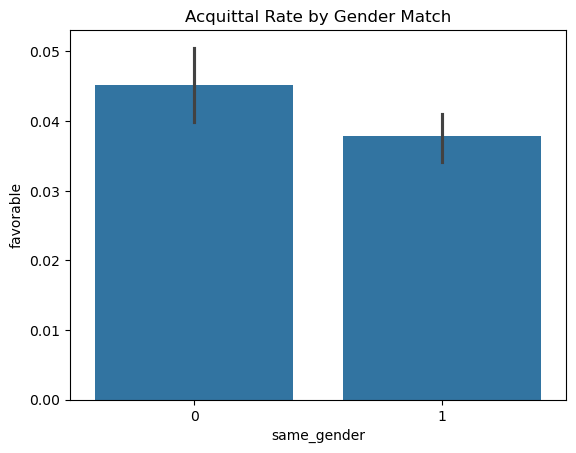

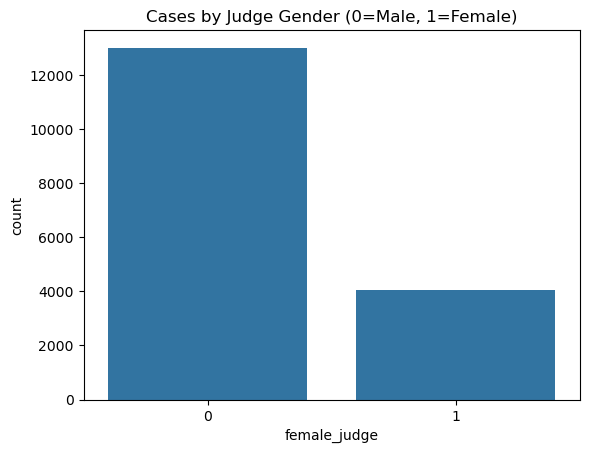

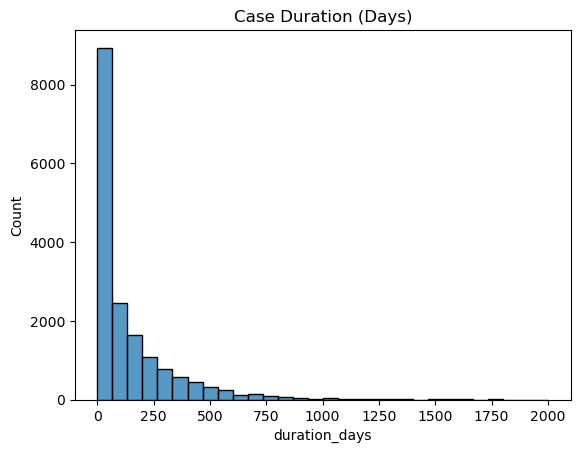

In [37]:
from matplotlib import pyplot as plt
import seaborn as sns
# Acquittal rate by gender match
sns.barplot(x='same_gender', y='favorable', data=df_clean)
plt.title("Acquittal Rate by Gender Match")
plt.show()

# Distribution of cases by judge gender
sns.countplot(x='female_judge', data=df_clean)
plt.title("Cases by Judge Gender (0=Male, 1=Female)")
plt.show()

# Case duration distribution
sns.histplot(df_clean['duration_days'], bins=30)
plt.title("Case Duration (Days)")
plt.show()

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ddl_case_id          100000 non-null  object        
 1   date_of_filing       100000 non-null  datetime64[ns]
 2   date_of_decision     100000 non-null  datetime64[ns]
 3   filing_year          100000 non-null  int64         
 4   state_code           100000 non-null  int64         
 5   court_no             100000 non-null  int64         
 6   female_defendant     100000 non-null  object        
 7   female_petitioner    100000 non-null  object        
 8   female_judge         100000 non-null  object        
 9   judge_tenure         100000 non-null  int64         
 10  act_s                100000 non-null  object        
 11  section_s            100000 non-null  object        
 12  bailable_ipc         59239 non-null   object        
 13  number_sections

In [40]:
import scipy.stats as stats

# Calculate Pearson correlation
r, p = stats.pearsonr(df_clean['judge_tenure'], df_clean['case_duration'])
print(f"Correlation: {r:.2f}, p-value: {p:.4f}")

KeyError: 'case_duration'